In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/hpo_analysis/pairwise_test_results.csv')

df.head()


,modelA,modelB,metric,pvalue,tstat,cohen_d,pval_corrected,reject_H0
0,model_10,model_14,runtime_cueq,2.816224e-04,-4.281114,-1.563242,1.267301e-02,True
1,model_10,model_18,runtime_cueq,1.560754e-04,-4.366855,-1.594550,7.023394e-03,True
2,model_10,model_2,runtime_cueq,4.967440e-15,15.523656,5.668438,2.235348e-13,True
3,model_10,model_22,runtime_cueq,5.357122e-16,-16.846258,-6.151384,2.410705e-14,True
4,model_10,model_30,runtime_cueq,8.399111e-01,-0.204163,-0.074550,1.000000e+00,False


In [2]:
df_runtime = df[df['metric'] == 'runtime_cueq']
df_rmse_f = df[df['metric'] == 'Default_default_final_rmse_f']

In [3]:
import pandas as pd
import numpy as np

def build_significance_matrix(df):
    """
    Builds an NxN matrix where rows/columns are model names.
    Each cell is:
     - 'S(+)' if reject_H0 == True and tstat > 0
     - 'S(-)' if reject_H0 == True and tstat < 0
     - 'NS' otherwise.
    """

    models = sorted(set(df["modelA"]).union(df["modelB"]))
    matrix = pd.DataFrame(index=models, columns=models, dtype=object)

    # Fill diagonal with dash
    for m in models:
        matrix.loc[m, m] = "-"

    # Populate the matrix
    for _, row in df.iterrows():
        A, B = row["modelA"], row["modelB"]
        if row["reject_H0"]:
            matrix.loc[A, B] = "S(+)" if row["tstat"] > 0 else "S(-)"
            # Also fill the opposite direction if needed
            matrix.loc[B, A] = "S(-)" if row["tstat"] > 0 else "S(+)"
        else:
            matrix.loc[A, B] = "NS"
            matrix.loc[B, A] = "NS"

    return matrix

# Example usage
signif_matrix_runtime = build_significance_matrix(df_runtime)
print(signif_matrix_runtime)

         model_10 model_14 model_18 model_2 model_22 model_30 model_34  \
model_10        -     S(-)     S(-)    S(+)     S(-)       NS     S(-)   
model_14     S(+)        -       NS    S(+)     S(-)       NS       NS   
model_18     S(+)       NS        -    S(+)     S(-)       NS     S(-)   
model_2      S(-)     S(-)     S(-)       -     S(-)     S(-)     S(-)   
model_22     S(+)     S(+)     S(+)    S(+)        -     S(+)     S(+)   
model_30       NS       NS       NS    S(+)     S(-)        -     S(-)   
model_34     S(+)       NS     S(+)    S(+)     S(-)     S(+)        -   
model_42     S(+)     S(+)     S(+)    S(+)       NS     S(+)     S(+)   
model_46     S(+)     S(+)     S(+)    S(+)     S(+)     S(+)     S(+)   
model_6      S(-)     S(-)     S(-)      NS     S(-)     S(-)     S(-)   

         model_42 model_46 model_6  
model_10     S(-)     S(-)    S(+)  
model_14     S(-)     S(-)    S(+)  
model_18     S(-)     S(-)    S(+)  
model_2      S(-)     S(-)      NS  


Figure saved to runtime_significance_heatmap.png


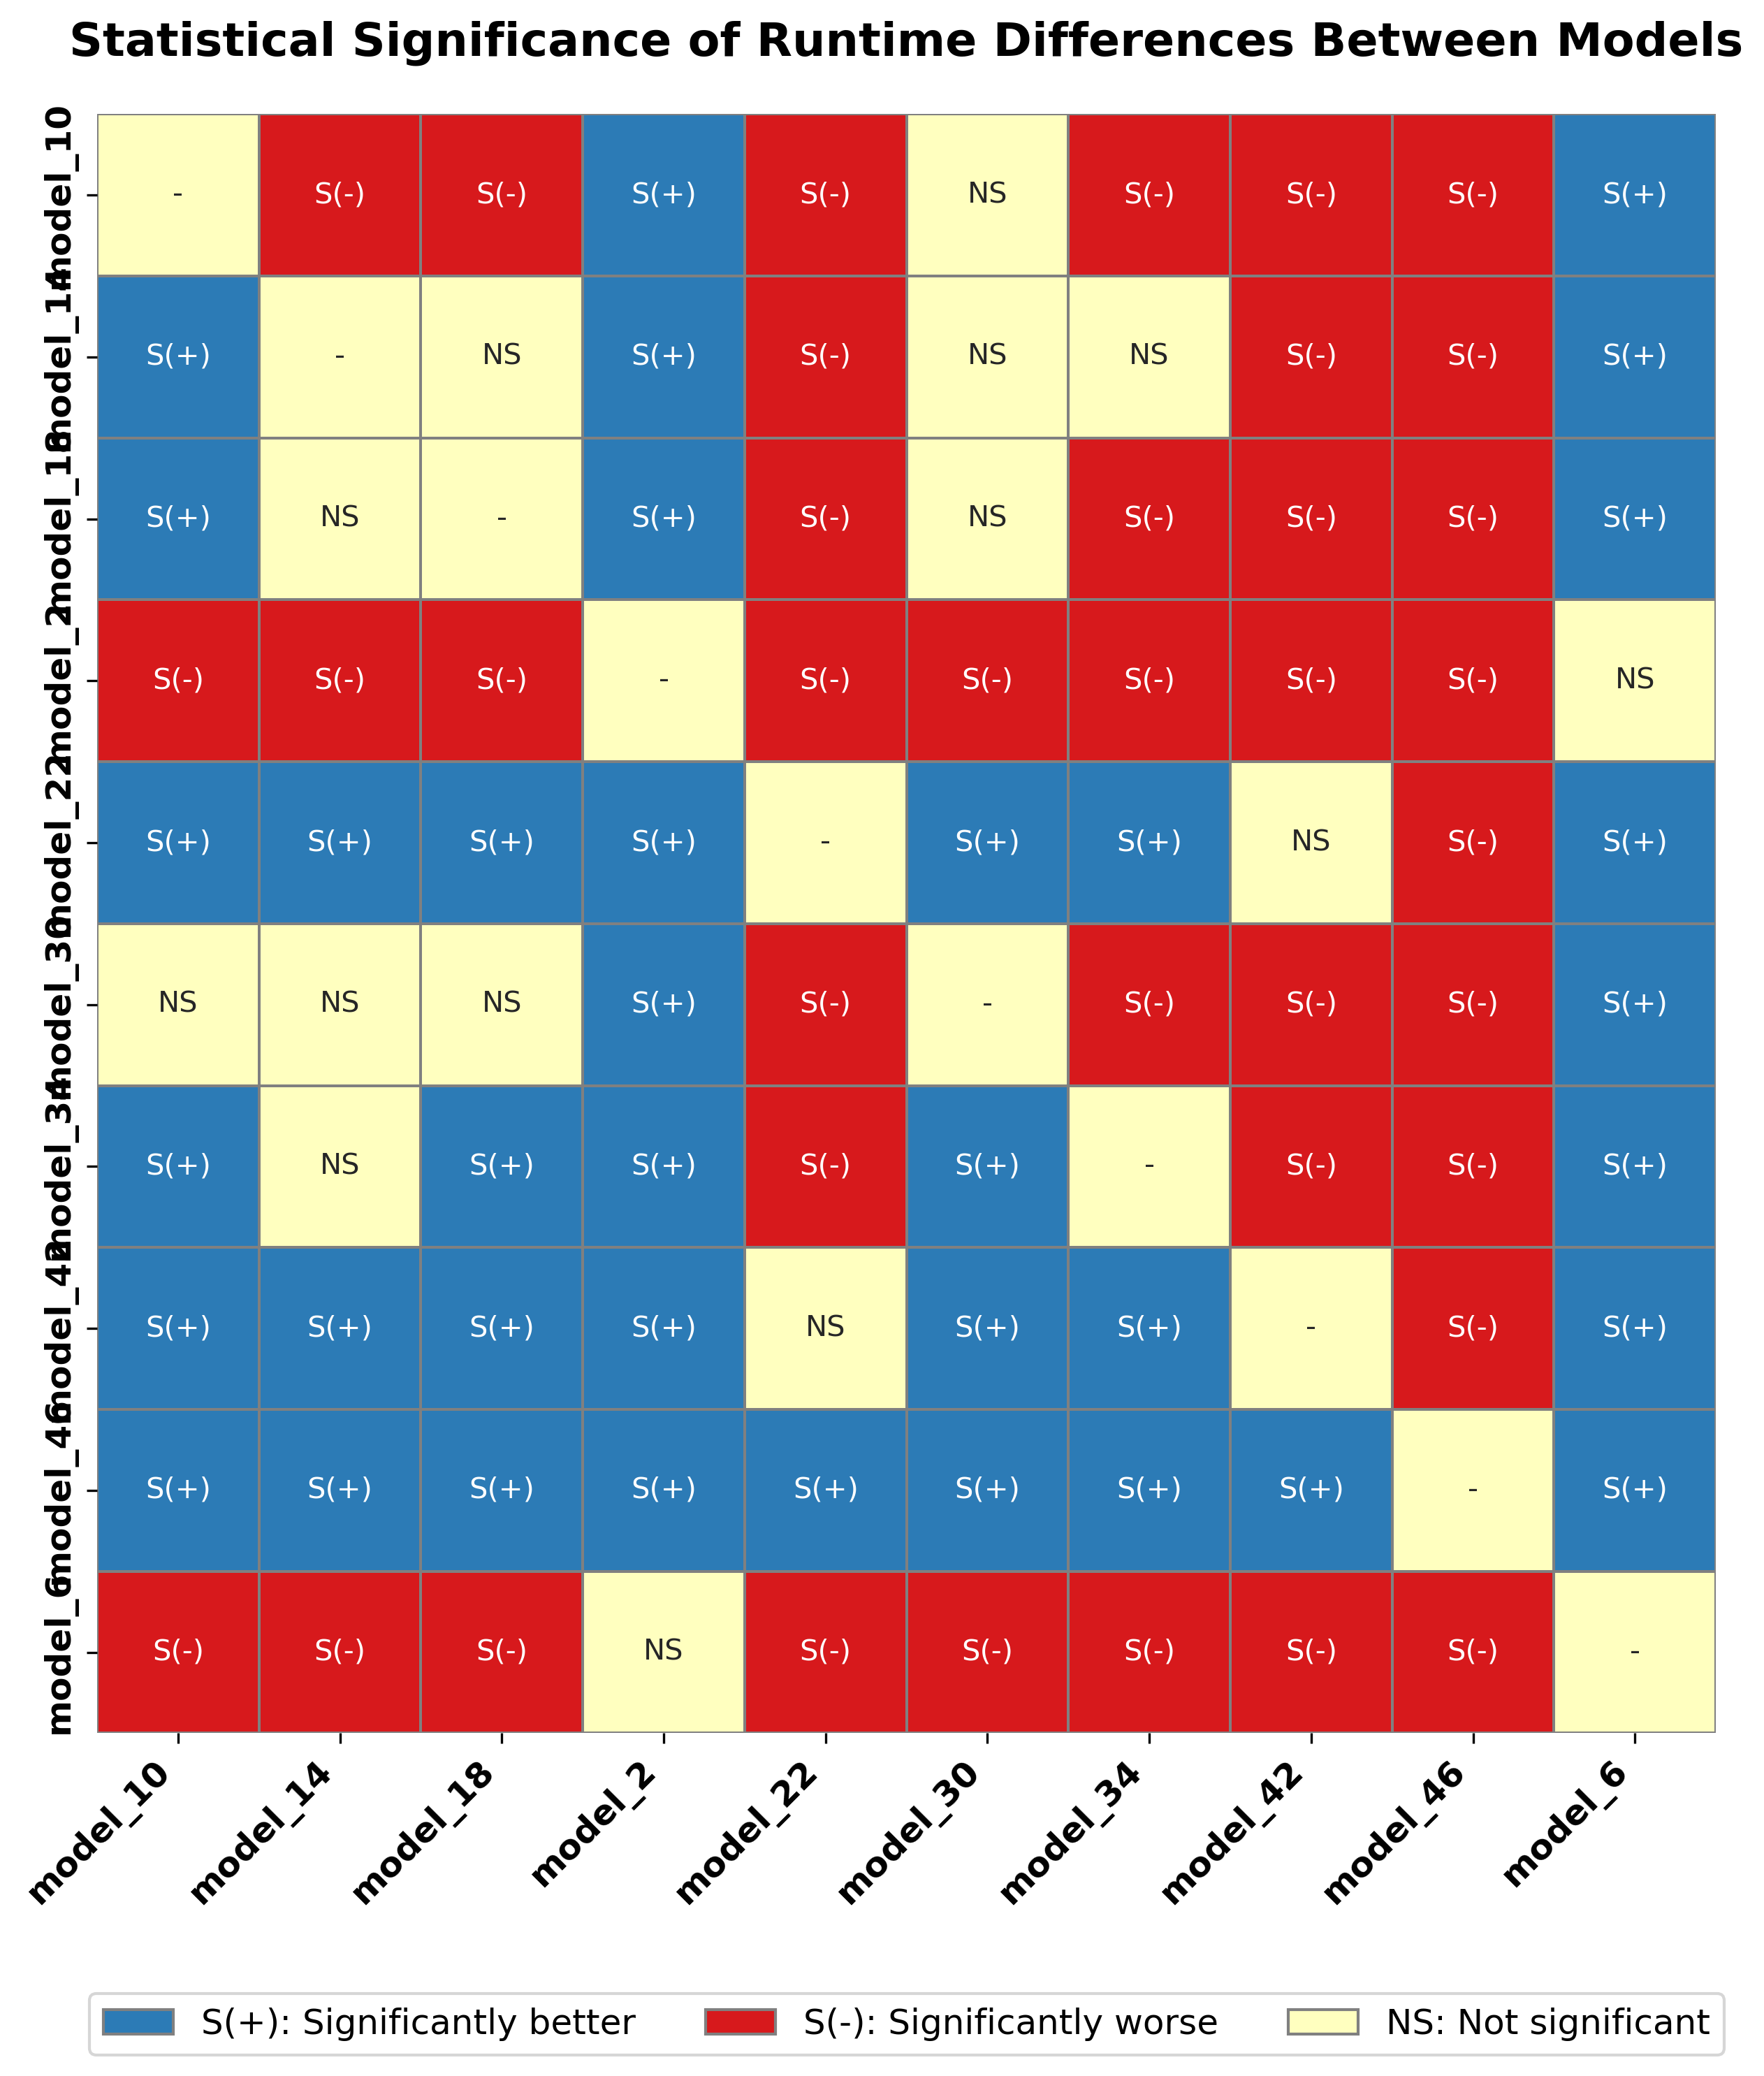

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def build_significance_matrix(df):
    """
    Builds an NxN matrix where rows/columns are model names.
    Each cell is:
     - 'S(+)' if reject_H0 == True and tstat > 0
     - 'S(-)' if reject_H0 == True and tstat < 0
     - 'NS' otherwise.
    """
    models = sorted(set(df["modelA"]).union(df["modelB"]))
    matrix = pd.DataFrame(index=models, columns=models, dtype=object)

    # Fill diagonal with dash
    for m in models:
        matrix.loc[m, m] = "-"

    # Populate the matrix
    for _, row in df.iterrows():
        A, B = row["modelA"], row["modelB"]
        if row["reject_H0"]:
            matrix.loc[A, B] = "S(+)" if row["tstat"] > 0 else "S(-)"
            # Also fill the opposite direction if needed
            matrix.loc[B, A] = "S(-)" if row["tstat"] > 0 else "S(+)"
        else:
            matrix.loc[A, B] = "NS"
            matrix.loc[B, A] = "NS"

    return matrix

def plot_significance_heatmap(matrix, title, figsize=(10, 8), cmap=None, save_path=None):
    """
    Creates a publication-quality heatmap from a significance matrix.
    
    Parameters:
    -----------
    matrix : pandas.DataFrame
        The significance matrix to visualize
    title : str
        Title for the heatmap
    figsize : tuple, optional
        Figure size (width, height) in inches
    cmap : matplotlib colormap, optional
        Custom colormap for the heatmap
    save_path : str, optional
        Path to save the figure
    """
    # Create a numerical representation for coloring
    num_matrix = pd.DataFrame(index=matrix.index, columns=matrix.columns, dtype=float)
    
    for i in matrix.index:
        for j in matrix.columns:
            if matrix.loc[i, j] == "S(+)":
                num_matrix.loc[i, j] = 1.0
            elif matrix.loc[i, j] == "S(-)":
                num_matrix.loc[i, j] = -1.0
            elif matrix.loc[i, j] == "NS":
                num_matrix.loc[i, j] = 0.0
            else:  # diagonal "-"
                num_matrix.loc[i, j] = 0.0
    
    # Ensure numeric type
    num_matrix = num_matrix.astype(float)
    
    # Set up the figure with high DPI for publication quality
    plt.figure(figsize=figsize, dpi=300)
    
    # Define a custom colormap if none provided
    if cmap is None:
        # High contrast colormap: red for S(-), white for NS, blue for S(+)
        cmap = ListedColormap(['#d7191c', '#ffffbf', '#2c7bb6'])
    
    # Create the heatmap
    ax = sns.heatmap(num_matrix, cmap=cmap, center=0, 
                     annot=matrix.values, fmt="", 
                     linewidths=0.5, linecolor='gray',
                     cbar=False, square=True)
    
    # Improve aesthetics for publication
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add a legend manually
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor='#2c7bb6', edgecolor='gray', label='S(+): Significantly better'),
        plt.Rectangle((0,0), 1, 1, facecolor='#d7191c', edgecolor='gray', label='S(-): Significantly worse'),
        plt.Rectangle((0,0), 1, 1, facecolor='#ffffbf', edgecolor='gray', label='NS: Not significant')
    ]
    plt.legend(handles=legend_elements, loc='upper center', 
               bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Figure saved to {save_path}")
    
    return ax

# Example usage
signif_matrix_runtime = build_significance_matrix(df_runtime)

# Plot the heatmap
plot_significance_heatmap(
    signif_matrix_runtime, 
    title="Statistical Significance of Runtime Differences Between Models",
    figsize=(12, 10),
    save_path="runtime_significance_heatmap.png"
)

plt.show()

In [7]:
def summarize_model_comparisons(df):
    """
    Returns a DataFrame with columns [model, better, worse, no_diff].
    'better' increments if reject_H0 == True and tstat > 0,
    'worse' increments if reject_H0 == True and tstat < 0,
    'no_diff' increments if reject_H0 == False.
    """

    models = sorted(set(df["modelA"]).union(df["modelB"]))
    summary_list = []

    for m in models:
        better, worse, no_diff = 0, 0, 0
        # Extract rows where modelA = m or modelB = m
        # We'll handle direction carefully
        df_mA = df[df["modelA"] == m]
        df_mB = df[df["modelB"] == m]

        # Count from modelA perspective
        for _, row in df_mA.iterrows():
            if row["reject_H0"]:
                if row["tstat"] > 0:
                    better += 1
                else:
                    worse += 1
            else:
                no_diff += 1

        # Count from modelB perspective
        for _, row in df_mB.iterrows():
            if row["reject_H0"]:
                # If B = m, but tstat>0 means modelA > modelB => this means m is 'worse'
                if row["tstat"] > 0:
                    worse += 1
                else:
                    better += 1
            else:
                no_diff += 1

        summary_list.append({
            "model": m,
            "better": better,
            "worse": worse,
            "no_diff": no_diff
        })

    return pd.DataFrame(summary_list).sort_values(by="better", ascending=False)


# Example usage
summary_runtime = summarize_model_comparisons(df_runtime)
print(f"Summary of runtime comparisons for metric {df_runtime['metric'].unique()[0]}")
print(summary_runtime)

Summary of runtime comparisons for metric runtime_cueq
      model  better  worse  no_diff
8  model_46       9      0        0
4  model_22       7      1        1
7  model_42       7      1        1
6  model_34       5      3        1
1  model_14       3      3        3
2  model_18       3      4        2
0  model_10       2      6        1
5  model_30       2      4        3
3   model_2       0      8        1
9   model_6       0      8        1


# STEP 4: Combine Significance with Effect Size

When you do want to highlight both significance and effect size (Cohen’s d), store them in the matrix or summary. For example, expand Step 2’s matrix to include effect-size info in parentheses if a difference is significant.

In [8]:
def build_significance_matrix_with_effect_size(df, d_threshold=0.5):
    """
    Builds an NxN matrix where each cell includes significance + effect size.
    For example:
     - 'S(+); d=1.2' if reject_H0 == True, tstat>0, and Cohen's d is 1.2
     - 'NS' otherwise.
    Use d_threshold to highlight effect sizes above a certain value.
    """

    models = sorted(set(df["modelA"]).union(df["modelB"]))
    matrix = pd.DataFrame("-", index=models, columns=models, dtype=object)

    for _, row in df.iterrows():
        A, B = row["modelA"], row["modelB"]
        if row["reject_H0"]:
            direction = "(+)" if row["tstat"] > 0 else "(-)"
            # Optionally highlight big effect sizes
            star = "*" if abs(row["cohen_d"]) >= d_threshold else ""
            text = f"S{direction}; d={row['cohen_d']:.2f}{star}"
            matrix.loc[A, B] = text
            # Opposite sign
            direction_opp = "(-)" if row["tstat"] > 0 else "(+)"
            text_opp = f"S{direction_opp}; d={-row['cohen_d']:.2f}{star}"
            matrix.loc[B, A] = text_opp
        else:
            matrix.loc[A, B] = "NS"
            matrix.loc[B, A] = "NS"

    return matrix

# Example usage
signif_matrix_with_d_runtime = build_significance_matrix_with_effect_size(df_runtime, d_threshold=0.8)
print(signif_matrix_with_d_runtime)

                model_10        model_14        model_18         model_2  \
model_10               -  S(-); d=-1.56*  S(-); d=-1.59*   S(+); d=5.67*   
model_14   S(+); d=1.56*               -              NS   S(+); d=5.59*   
model_18   S(+); d=1.59*              NS               -   S(+); d=7.42*   
model_2   S(-); d=-5.67*  S(-); d=-5.59*  S(-); d=-7.42*               -   
model_22   S(+); d=6.15*   S(+); d=2.71*   S(+); d=4.47*  S(+); d=12.89*   
model_30              NS              NS              NS   S(+); d=4.41*   
model_34   S(+); d=3.41*              NS   S(+); d=1.71*   S(+); d=9.92*   
model_42   S(+); d=8.36*   S(+); d=3.27*   S(+); d=6.20*  S(+); d=18.48*   
model_46  S(+); d=23.50*  S(+); d=14.26*  S(+); d=21.76*  S(+); d=32.90*   
model_6   S(-); d=-5.18*  S(-); d=-5.14*  S(-); d=-7.10*              NS   

                 model_22        model_30        model_34         model_42  \
model_10   S(-); d=-6.15*              NS  S(-); d=-3.41*   S(-); d=-8.36*   
model_1

# STEP 5:

In [9]:
def get_mean_performance(df_full, metric_column="runtime_cueq"):
    """
    Extract each model's mean performance from a separate DataFrame.
    df_full might be your original cross-validation results, not just pairwise tests.
    Returns a DataFrame with columns [model, mean_perf].
    """
    # Suppose df_full has columns: [model, performance_value]...
    # For demonstration, assume model name is in 'parsed_model' and performance in 'runtime_cueq'
    grouped = df_full.groupby("parsed_model")[metric_column].mean().reset_index()
    grouped.columns = ["model", "mean_perf"]
    return grouped.sort_values("mean_perf")

def build_tiers(ranked_models, df_signif):
    """
    Given a list of models sorted by mean performance, partition them into tiers.
    If two adjacent models are NOT significantly different, they go in the same tier.
    df_signif: significance table (modelA, modelB, reject_H0, tstat).
    """

    # We'll transform df_signif into a lookup dict for "are A,B significantly different?"
    significant_pairs = set()
    for _, row in df_signif.iterrows():
        A, B = row["modelA"], row["modelB"]
        # We'll say the pair is significant if reject_H0 == True
        if row["reject_H0"]:
            significant_pairs.add(tuple(sorted([A, B])))

    tiers = []
    current_tier = [ranked_models[0]]

    def are_significant(mA, mB):
        return tuple(sorted([mA, mB])) in significant_pairs

    # Walk through sorted models, decide if we start a new tier
    for i in range(1, len(ranked_models)):
        prev_model = ranked_models[i - 1]
        this_model = ranked_models[i]
        # If they are significantly different, start a new tier
        if are_significant(prev_model, this_model):
            tiers.append(current_tier)
            current_tier = [this_model]
        else:
            # Not significant => same tier
            current_tier.append(this_model)

    if current_tier:
        tiers.append(current_tier)

    return tiers

# Example usage:
# Suppose you have df_full (all CV runs with runtime info).
# 1) get mean performance
mean_df = get_mean_performance(df, metric_column="runtime_cueq")
# 2) build tiers
sorted_model_list = mean_df["model"].tolist()
tiers = build_tiers(sorted_model_list, df_runtime)
print("Tiers:", tiers)

KeyError: 'parsed_model'